# ISIDORA data check

In [1]:
from __future__ import print_function
import cProfile
import pandas as pd
import tables as tb
import numpy as np
from Util import *
import time
import mplFunctions as mpl
import wfmFunctions as wfm
import sensorFunctions as snf
import tblFunctions as tbl
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8) # Bigger plots
%matplotlib inline
%load_ext autoreload
%autoreload 2
print("This notebook has been run last on {} at {}.".format(time.strftime("%d/%m/%Y"),time.strftime("%H:%M:%S")))


This notebook has been run last on 16/10/2016 at 10:47:25.


In [26]:
def IntegrateTrue(twf):
    return twf.sum().sum(axis=1).ene_pes

def IntegrateRaw(rwf):
    transformed = 2500-rwf
    return IntegrateCorr(transformed)
#    return np.sum( [ai - np.mean( ai[ np.where(abs(ai-np.mean(ai))<np.std(ai)) ] ) for ai in a ] )

def IntegrateCorr(cwf):
    return cwf[np.where( abs( cwf - np.mean(cwf) ) > 2.*np.std(cwf) )].sum()
    #return cwf.sum()

ISIDORA RUN WITH thr1 = 3, thr2 = 0, thr3 = 5

In [6]:
%less ../../../Config/ISIDORA_NA_ZLIB_test2.csv

In [3]:
%ls -lh '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_ACTIVE_5bar_int_blr_on_1000.h5'

-rw-r--r--  1 jjgomezcadenas  staff   1.6G Oct 16 03:57 /Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_ACTIVE_5bar_int_blr_on_1000.h5


In [5]:
h5f =tb.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_ACTIVE_5bar_int_blr_on_1000.h5')

In [7]:
h5f

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_ACTIVE_5bar_int_blr_on_1000.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=1, complib='zlib', shuffle=True, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/BLR (Group) ''
/BLR/acum (EArray(0, 48000), shuffle, zlib(1)) ''
  atom := Int32Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 48000)
/BLR/baseline (EArray(0, 12), shuffle, zlib(1)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (2730, 12)
/BLR/mau (EArray(0, 48000), shuffle, zlib(1)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 48000)
/BLR/pulse_on (EArray(0, 48000), shuffle, zlib(1)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 48000)
/BLR/wa

In [8]:
pmttwf  = h5f.root.TWF.PMT
sipmtwf = h5f.root.TWF.SiPM
pmtblr  = h5f.root.RD.pmtblr
pmtcwf  = h5f.root.RD.pmtcwf
pmtrwf  = h5f.root.RD.pmtrwf
sipmrwf = h5f.root.RD.sipmrwf
pmtdf   = snf.read_data_sensors(h5f.root.Sensors.DataPMT)
sipmdf  = snf.read_data_sensors(h5f.root.Sensors.DataSiPM)

In [14]:
pmtdf

,active,adc_to_pes,channel,gain,x,y
0,1,-22.916800,0,0.001641,-23.941401,65.778503
1,1,-23.750999,1,0.001623,-44.995098,-53.623100
2,1,-25.300800,2,0.000000,68.936501,-12.155400
3,1,-25.998400,3,0.000000,-0.000000,185.000000
4,1,-23.707399,4,0.001596,-118.916000,141.718002
5,1,-20.892700,5,0.001581,-182.188995,32.124901
6,1,-22.134001,6,0.000000,-160.214996,-92.500000
7,1,-33.099300,7,0.000000,-63.273701,-173.843002
8,1,-20.437700,8,0.001622,63.273701,-173.843002
9,1,-25.169800,9,0.001601,160.214996,-92.500000


## Check PMT CWF

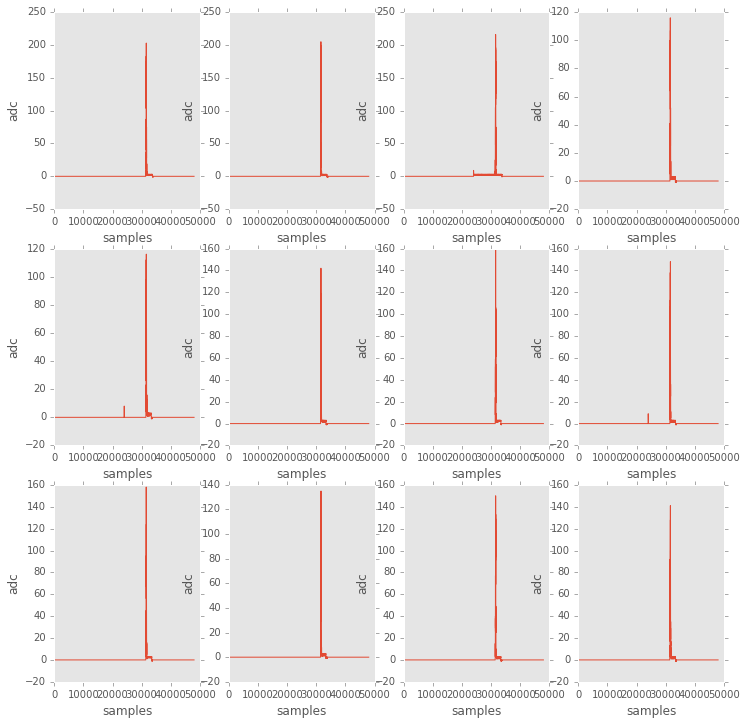

In [9]:
mpl.plot_waveforms(dict(enumerate(pmtcwf[0])))

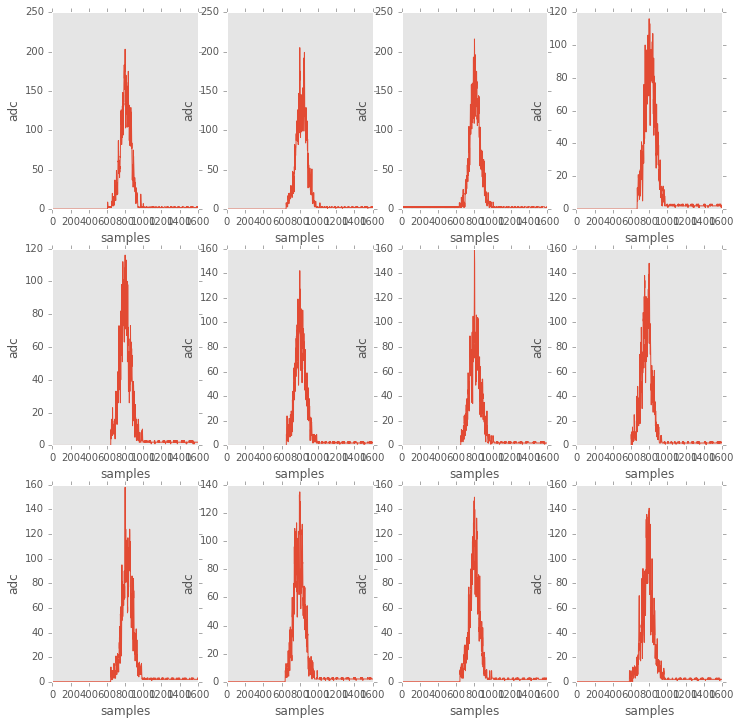

In [10]:
mpl.plot_waveforms(dict(enumerate(pmtcwf[0])),zoom=True)

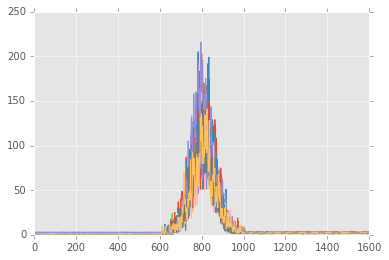

In [11]:
mpl.overlap_waveforms(pmtcwf,0)

### Compare CWF with BLR

RED  = CWF

BLUE = BLR

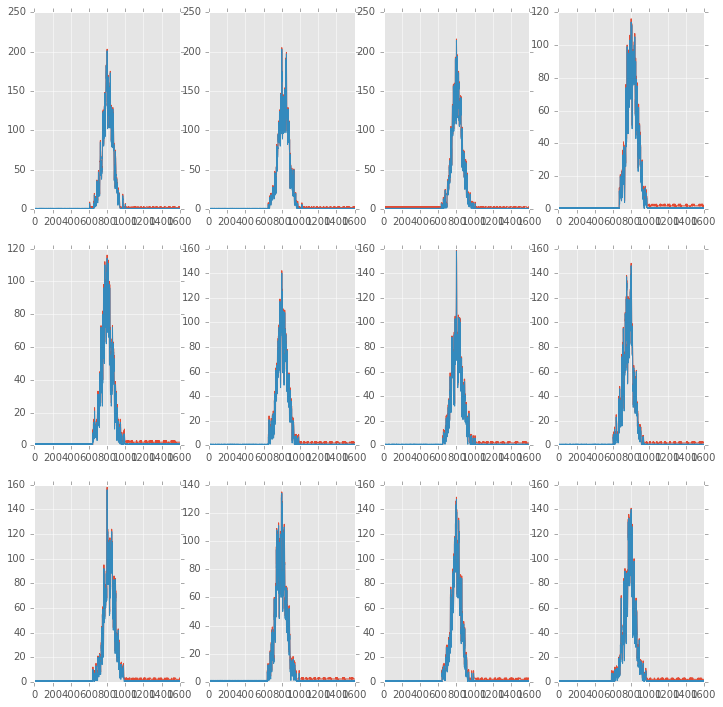

In [12]:
mpl.compare_corr_raw(pmtcwf,pmtblr,0)

### Compare CWF with RWF

RED  = CWF

BLUE = RWF

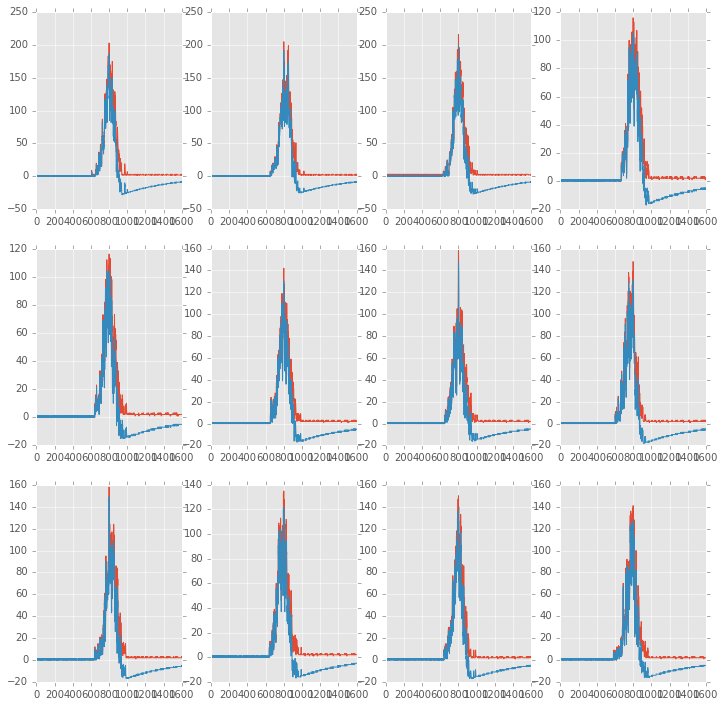

In [13]:
mpl.compare_corr_raw(pmtcwf,pmtrwf,0)

### Compare areas

#### NB: comparison must be made at the level of S2 pulse, to aovid adding tail noise

In [ ]:
def waveform_panel(pmtrwf,pmtdf,mau_len = 500, calib_constat =True, adc_to_pes=20,
                   type = 'PMT', daq_ceiling=4096, event=0):
    """
    input: sensor (pmt or sipm) data vector, sensor data frame (position, calibration)
    returns: a panel holding DataFrames with waveforms for all sensors, and a series for the baselines
    """
    PMT = {}
    nm = mau_len
    B_MAU = (1./nm)*np.ones(nm)
    pmt_len = pmtrwf.shape[2]
    NPMT = pmtrwf.shape[1]
    MAU = np.zeros(nm)
    BSL = {}

    time_ns = np.arange(pmt_len)*mus
    indx = np.arange(pmt_len)

    if type == 'PMT':
        time_ns = np.arange(pmt_len)*FP.time_DAQ

    ene_sum = 0
    for j in range(NPMT):

        if calib_constat == True:
            adc_to_pes = abs(pmtdf['adc_to_pes'][j])

        signal_daq = pmtrwf[event,j]
        if type == 'PMT':
            signal_daq = daq_ceiling - pmtrwf[event,j]

        MAU[0:nm] = SGN.lfilter(B_MAU,1, signal_daq[0:nm])
        BASELINE = MAU[nm-1]

        ene_pes = (signal_daq - BASELINE)/adc_to_pes
        if type == 'PMT':
            ene_sum += ene_pes

        PMT[j] = wfdf(time_ns,ene_pes,indx)
        BSL[j] = BASELINE
    PMT[j+1] = wfdf(time_ns,ene_sum,indx)
    return pd.Panel(PMT),pd.Series(BSL)

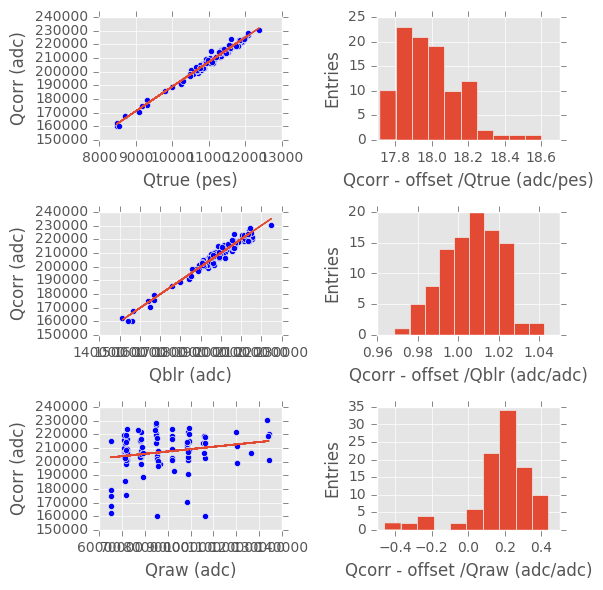

In [27]:
qtrue, qraw, qblr, qcor = [], [], [], []
poly = lambda x: coefs[1] + coefs[0]*x

for i in np.arange(100):
    twf = tbl.read_wf_table(pmttwf,i)
    rwf = pmtrwf[i]
    blr = pmtblr[i]
    cwf = pmtcwf[i]
    qtrue += [IntegrateTrue(twf)]
    qraw  += [IntegrateRaw(rwf)]
    qblr  += [IntegrateRaw(blr)]
    qcor  += [IntegrateCorr(cwf)]

qtrue = np.array(qtrue)
qraw  = np.array(qraw)
qblr  = np.array(qblr)
qcor  = np.array(qcor)

plt.figure( figsize = (6,6) )

plt.subplot(3,2,1)
plt.scatter(qtrue,qcor)
coefs = np.polyfit(qtrue,qcor,1)
qcor_fit = map( poly, qtrue )
plt.plot(qtrue,qcor_fit)
plt.xlabel('Qtrue (pes)')
plt.ylabel('Qcorr (adc)')

plt.subplot(3,2,2)
h = plt.hist((qcor-coefs[1])/qtrue,bins=10)
plt.xlabel('Qcorr - offset /Qtrue (adc/pes)')
plt.ylabel('Entries')

plt.subplot(3,2,3)
plt.scatter(qblr,qcor)
coefs = np.polyfit(qblr,qcor,1)
qcor_fit = map( poly, qblr )
plt.plot(qblr,qcor_fit)

plt.xlabel('Qblr (adc)')
plt.ylabel('Qcorr (adc)')

plt.subplot(3,2,4)
h = plt.hist( (qcor-coefs[1])/qblr, bins = 10 )
plt.xlabel('Qcorr - offset /Qblr (adc/adc)')
plt.ylabel('Entries')

plt.subplot(3,2,5)
plt.scatter(qraw,qcor)
coefs = np.polyfit(qraw,qcor,1)
qcor_fit = map( poly, qraw )
plt.plot(qraw,qcor_fit)

plt.xlabel('Qraw (adc)')
plt.ylabel('Qcorr (adc)')

plt.subplot(3,2,6)
h = plt.hist( (qcor-coefs[1])/qraw, bins = 10 )
plt.xlabel('Qcorr - offset /Qraw (adc/adc)')
plt.ylabel('Entries')

plt.tight_layout()


# THRESHOLDS = 5.0, 2.0, 3.0

In [ ]:
# %load /Users/Gonzalo/github/IC/Config/ISIDORA_default.csv
# Configuration file for ISIDORA
# The parameters for ISIDORA are:
#
#        PATH_IN = path to DST file
#        FILE_IN = name of DST file
#        FIRST_EVT,LAST_EVT,RUN_ALL,
#
#        RUN_ALL is used to decide whether to run all the events in the file
#        in case that the total number of events requested (LAST_EVT-FIRST_EVT)
#        exceeds the number of events in the DST file. If RUN_ALL is set to 1 (True),
#        the script will run over all elements in the DST,
#        otherwise it will exit with a warning.
#
#		 COEF decides whether to use CA (COEF = 0) or AC (COEF =1)
#
#        CA = Nominal (measured) values of the capacitors defining the filter
#        AC = nominal (measured) values of the accumulator
#        MAU_LEN = length of MAU
#        NSIGMA1 number of sigmas for thr1
#        NSIGMA2 number of sigmas for thr2
#        NSIGMA3 number of sigmas for thr3
#
#
PATH_IN,FILE_IN,FIRST_EVT,LAST_EVT,RUN_ALL,COEF,CA,AC,MAU_LEN,NSIGMA1,NSIGMA2,NSIGMA3,END
#
/Users/Gonzalo/github/IC/data/,DIOMIRA0.h5,0,100,1,0,6.02975448 6.22547194 6.0671337 6.22159457 6.29999787 6.09892384 6.18289435 6.21775591 6.19306671 6.30518792 6.20359891 6.312311921,0.0017643 0.00170883 0.00175343 0.0017099 0.00168862 0.00174429 0.0017206 0.00171095 0.00171778 0.00168723 0.00171486 0.00168533,250,5.0,2.0,3.0,1


In [16]:
# open file and check its contents
h5f = tb.open_file('/Users/Gonzalo/github/IC/data/DIOMIRA0_523.h5')
print(h5f)

/Users/Gonzalo/github/IC/data/DIOMIRA0_523.h5 (File) ''
Last modif.: 'Sat Oct 15 23:57:29 2016'
Object Tree: 
/ (RootGroup) ''
/BLR (Group) ''
/BLR/acum (EArray(100, 32000), shuffle, zlib(1)) ''
/BLR/baseline (EArray(100, 12), shuffle, zlib(1)) ''
/BLR/mau (EArray(100, 32000), shuffle, zlib(1)) ''
/BLR/pulse_on (EArray(100, 32000), shuffle, zlib(1)) ''
/BLR/wait_over (EArray(100, 32000), shuffle, zlib(1)) ''
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
/MC (Group) ''
/MC/FEE (Table(1,)) 'EP-FEE parameters'
/MC/MCTracks (Table(806,), zlib(1)) ''
/RD (Group) ''
/RD/pmtblr (EArray(100, 12, 32000), shuffle, zlib(1)) ''
/RD/pmtcwf (EArray(100, 12, 32000), shuffle, zlib(1)) ''
/RD/pmtrwf (EArray(100, 12, 32000), shuffle, zlib(1)) ''
/RD/sipmrwf (EArray(100, 1789, 800), shuffle, zlib(1)) ''
/Sensors (Group) ''
/Sensors/DataPMT (Table(12,)) ''
/Sensors/DataSiPM (Table(1789,)) ''
/TWF (Group) ''
/TWF/PMT (Table(1420,), shuffle, zlib(1)) 'Store for PMTs TWF'
/TWF/SiPM (Table(10

In [17]:
pmttwf  = h5f.root.TWF.PMT
sipmtwf = h5f.root.TWF.SiPM
pmtblr  = h5f.root.RD.pmtblr
pmtcwf  = h5f.root.RD.pmtcwf
pmtrwf  = h5f.root.RD.pmtrwf
sipmrwf = h5f.root.RD.sipmrwf
pmtdf   = snf.read_data_sensors(h5f.root.Sensors.DataPMT)
sipmdf  = snf.read_data_sensors(h5f.root.Sensors.DataSiPM)

## Check PMT CWF

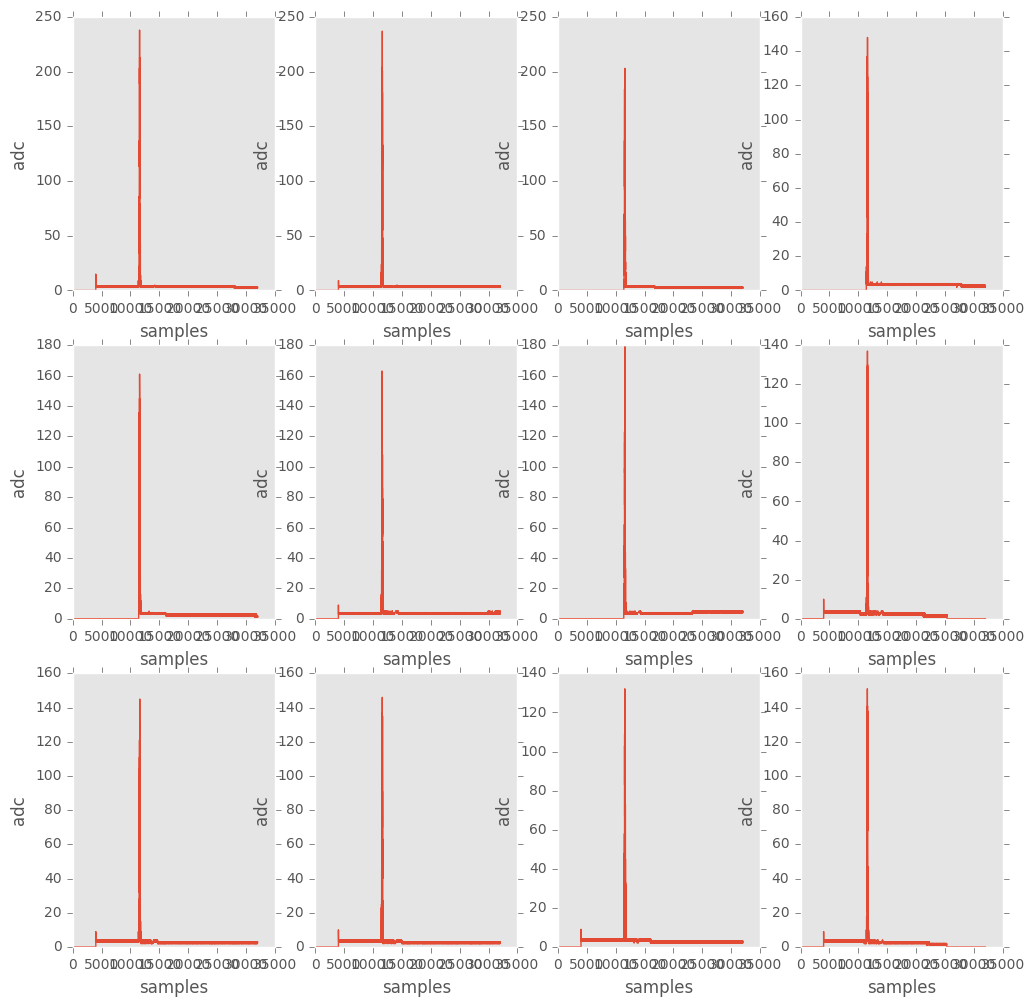

In [18]:
mpl.plot_waveforms(dict(enumerate(pmtcwf[0])))

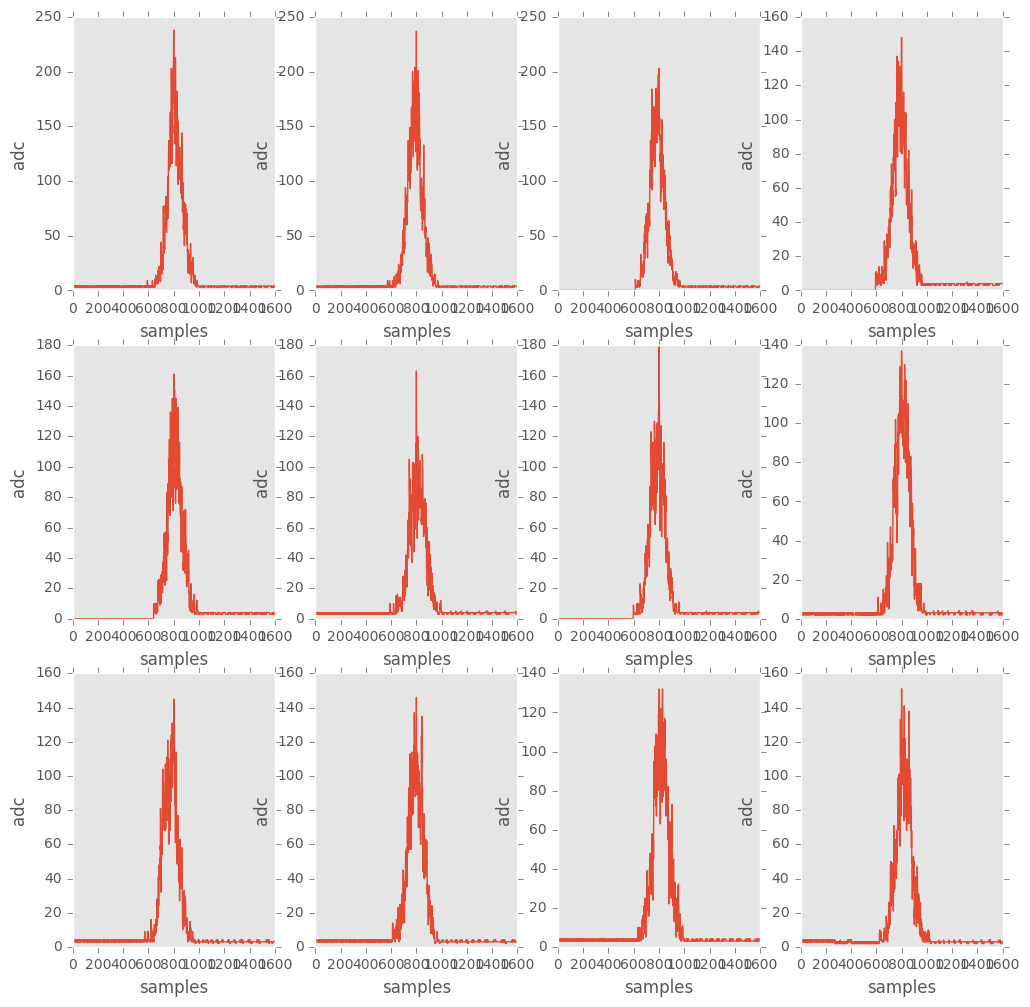

In [19]:
mpl.plot_waveforms(dict(enumerate(pmtcwf[0])),zoom=True)

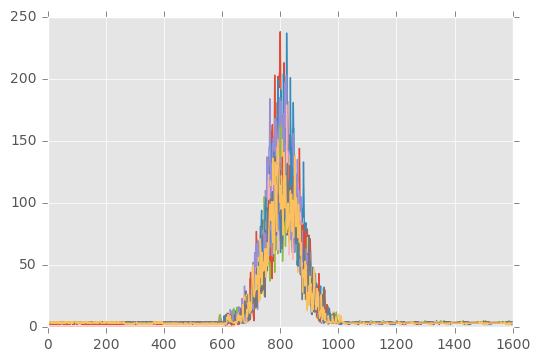

In [20]:
mpl.overlap_waveforms(pmtcwf,0)

## Compare CWF with BLR

RED  = CWF

BLUE = BLR

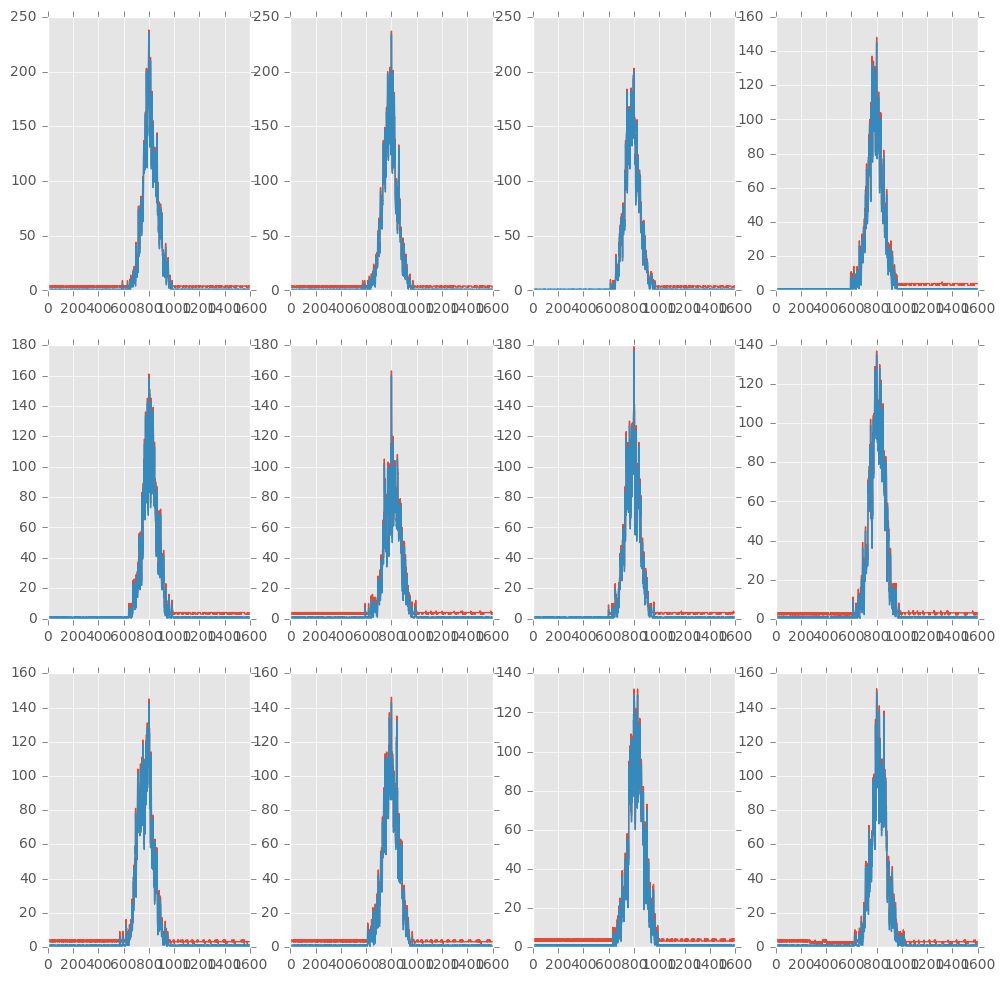

In [21]:
mpl.compare_corr_raw(pmtcwf,pmtblr,0)

## Compare CWF with RWF

RED  = CWF

BLUE = RWF

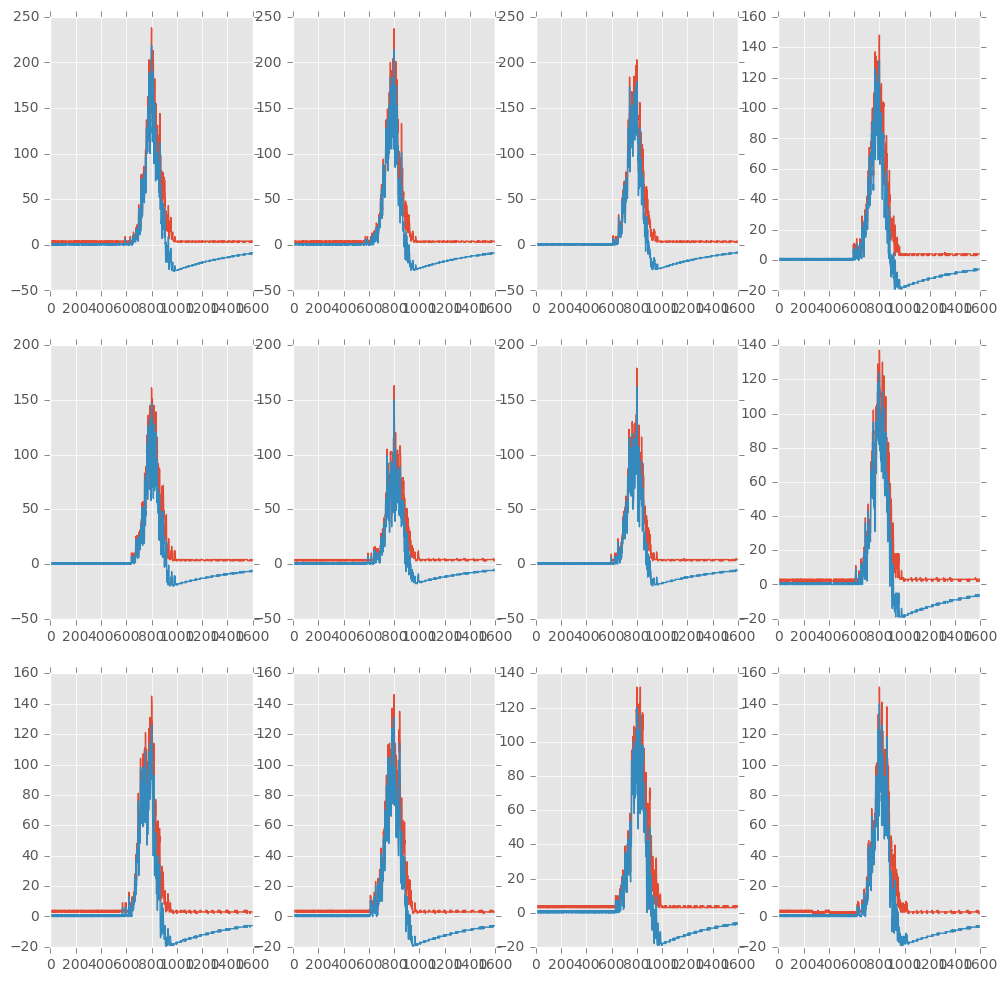

In [22]:
mpl.compare_corr_raw(pmtcwf,pmtrwf,0)

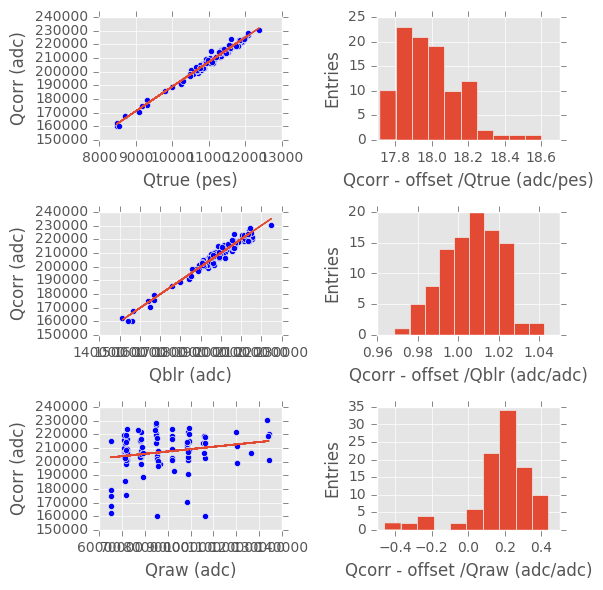

In [28]:
qtrue, qraw, qblr, qcor = [], [], [], []
poly = lambda x: coefs[1] + coefs[0]*x

for i in np.arange(100):
    twf = tbl.read_wf_table(pmttwf,i)
    rwf = pmtrwf[i]
    blr = pmtblr[i]
    cwf = pmtcwf[i]
    qtrue += [IntegrateTrue(twf)]
    qraw  += [IntegrateRaw(rwf)]
    qblr  += [IntegrateRaw(blr)]
    qcor  += [IntegrateCorr(cwf)]

qtrue = np.array(qtrue)
qraw  = np.array(qraw)
qblr  = np.array(qblr)
qcor  = np.array(qcor)

plt.figure( figsize = (6,6) )

plt.subplot(3,2,1)
plt.scatter(qtrue,qcor)
coefs = np.polyfit(qtrue,qcor,1)
qcor_fit = map( poly, qtrue )
plt.plot(qtrue,qcor_fit)
plt.xlabel('Qtrue (pes)')
plt.ylabel('Qcorr (adc)')

plt.subplot(3,2,2)
h = plt.hist((qcor-coefs[1])/qtrue,bins=10)
plt.xlabel('Qcorr - offset /Qtrue (adc/pes)')
plt.ylabel('Entries')

plt.subplot(3,2,3)
plt.scatter(qblr,qcor)
coefs = np.polyfit(qblr,qcor,1)
qcor_fit = map( poly, qblr )
plt.plot(qblr,qcor_fit)

plt.xlabel('Qblr (adc)')
plt.ylabel('Qcorr (adc)')

plt.subplot(3,2,4)
h = plt.hist( (qcor-coefs[1])/qblr, bins = 10 )
plt.xlabel('Qcorr - offset /Qblr (adc/adc)')
plt.ylabel('Entries')

plt.subplot(3,2,5)
plt.scatter(qraw,qcor)
coefs = np.polyfit(qraw,qcor,1)
qcor_fit = map( poly, qraw )
plt.plot(qraw,qcor_fit)

plt.xlabel('Qraw (adc)')
plt.ylabel('Qcorr (adc)')

plt.subplot(3,2,6)
h = plt.hist( (qcor-coefs[1])/qraw, bins = 10 )
plt.xlabel('Qcorr - offset /Qraw (adc/adc)')
plt.ylabel('Entries')

plt.tight_layout()
